# NEO Sky Prediction

In this second-last notebook we will use a Kernel Density Estimator (KDE) on our enriched NEO data from the Granvik et al. (2018) model! The idea: We want to get a realistic probability density function (PDF) of NEOs in the night sky. Additionally, we want to filter "NEOs of interest", e.g., based on the apparent magnitude or orbital elements, to get a better understanding and "feeling" where we should point our telescopes for maximum detection output!

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import re
import requests
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import sklearn
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [2]:
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

In [3]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [4]:
# Load the Granvik model
data_dir = pathlib.Path("results_data/Granvik")
data_dir.mkdir(parents=True, exist_ok=True)
dataframe_filepath = data_dir / "enriched_granvik_model_w_appmag.parquet"

granvik_model_df = pd.read_parquet(dataframe_filepath)

# As shown in previous notebooks, we need to transform the longitude values to plot them in a
# matplotlib map projection
granvik_model_df.loc[:, "earth2neo_eclip_long_4plot"] = \
    granvik_model_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi)
                                                             if x > np.pi
                                                             else -1*x)

## Filter NEO model

Let's filter our model data and take a look at the corresponding scatter plot of the sky coordinates

In [5]:
# In this cell, you can filter the data as you wish!
filtered_granvik_model_df = granvik_model_df[granvik_model_df[f"ang_dist_neo2sun_deg"] >= 45.0].copy()
filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"app_mag"] <= 25.0)].copy()
#filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"Ecc_"] > 0.5)].copy()

# Please note: We obtain the latitude and THEN the longitude. Why? Take a look at the KDE cell.
neo_positions_coord = filtered_granvik_model_df[["earth2neo_eclip_lat",
                                                 "earth2neo_eclip_long_4plot"]].values

In [6]:
print(f"Number of de-enriched NEOs: {len(neo_positions_coord) / 6}")

Number of de-enriched NEOs: 19379.5


In [7]:
# Get th ET and ...
time_et = granvik_model_df["epoch_et"].iloc[0]

# ... determine the positional vector of the Sun as seen from Earth and compute the corresponding
# sky coordiantes
earth2sun_position_vec = spiceypy.spkgps(targ=10,
                                         et=time_et,
                                         ref="ECLIPJ2000",
                                         obs=399)[0]
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# Convert the values to determine the "Opposition Direction"
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2.0 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# We need to transform the longitude values for matplotlib
sun_ecl_long_4plot = \
    -1*((sun_ecl_long % np.pi) - np.pi) if sun_ecl_long > np.pi else -1*sun_ecl_long
sun_opp_ecl_long_4plot = \
    -1*((sun_opp_ecl_long % np.pi) - np.pi) if sun_opp_ecl_long > np.pi else -1*sun_opp_ecl_long

Text(0, 0.5, 'Ecl. lat. in deg.')

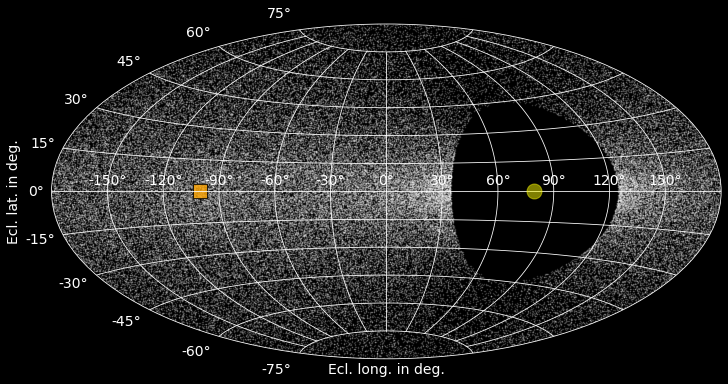

In [8]:
# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Add the NEOs
plt.scatter(neo_positions_coord[:, 1],
            neo_positions_coord[:, 0],
            marker=".",
            s=1,
            alpha=0.2,
            color="white")

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.scatter(sun_opp_ecl_long_4plot,
            sun_opp_ecl_lat,
            color="orange",
            marker="s",
            s=200,
            alpha=0.8,
            edgecolor='black')

plt.xlabel("Ecl. long. in deg.")
plt.ylabel("Ecl. lat. in deg.")

## Kernel Density Estimator

Now use a KDE to create a density plot! Please note: we use the haversine metric that requires the input order "latitude / longitude" (see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)).

Additionally, we use an exponential kernel.

Sampling vectors on a unit-sphere can be done with the [von Mises-Fisher distribution](https://en.wikipedia.org/wiki/Von_Mises–Fisher_distribution). A von Mises-Fisher based kernel would be the best approach. However, currently there is no implementation in scikit-learn. Some less known "side-project" repositories offer miscellaneous solutions. Here, we stay with default kernels and bandwidths.

In [9]:
# We apply a broad kerne with a size of 5 degrees to smooth the resulting distribution
import sklearn.neighbors
kde = sklearn.neighbors.KernelDensity(bandwidth=np.radians(5),
                                      metric="haversine",
                                      kernel="exponential",
                                      algorithm="ball_tree")
kde.fit(neo_positions_coord)

KernelDensity(algorithm='ball_tree', bandwidth=0.08726646259971647,
              kernel='exponential', metric='haversine')

In [10]:
# Compute the PDF in a long-lat mesh grid
sample_lat, sample_long = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, 100),
                                      np.linspace(-np.pi, np.pi, 100))
latlong = np.vstack([sample_lat.ravel(),
                     sample_long.ravel()]).T
sky_pdf = np.exp(kde.score_samples(latlong))
sky_pdf = sky_pdf.reshape(sample_lat.shape)

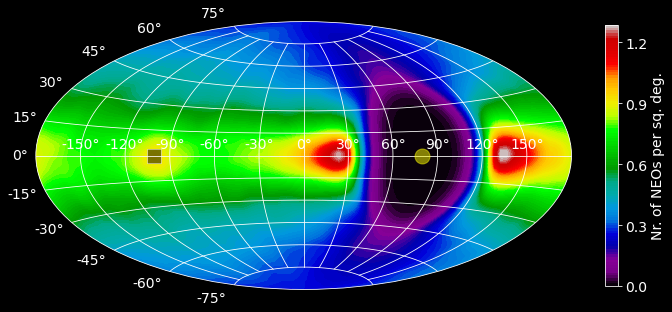

In [11]:
# We plot now the final figure of the sky-based PDF

# First we compute the resulting NEO density in 1/deg^2. Use the PDF, consider the number of all
# NEOs (len(neo_positions_coord)). This leads to the number of NEOs per Steradian. We apply now
# (180/pi)^2 to convert the result to NEOs/deg^2. However, since we enriched the NEO model in script
# number 12 by a factor of 6 we need to divide it by 6 to obtain the final density
neo_density = sky_pdf * len(neo_positions_coord)/(180/math.pi)**2 / 6

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Create a color contour plot (filled)
CS = plt.contourf(sample_long,
                  sample_lat,
                  neo_density,
                  levels=np.linspace(0, np.max(neo_density), 100),
                  cmap=plt.cm.nipy_spectral)
cbar = plt.colorbar(CS, shrink=0.6)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label("Nr. of NEOs per sq. deg.")

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.scatter(sun_opp_ecl_long_4plot,
            sun_opp_ecl_lat,
            color="black",
            marker="s",
            s=200,
            alpha=0.5,
            edgecolor='white')

## Outlook

In our next, as last, notebook we will add telescope properties and settings. If you have power-machine or if you want to run it in a scalable cloud solution, feel free to add the interactive features from notebook 09!